# NCF

Done without book metadata, using solely the rating given by users for books read in the past

## Import Libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

## Read Data

In [2]:
train_data = pd.read_csv('train_interactions.csv')
test_data = pd.read_csv('test_interactions.csv')

In [3]:
print(train_data.shape)
train_data.head(3)

(134745, 7)


,user_id,book_id,rating,date_added,n_votes,review_age,sentiment
0,0,157993,5,2016-07-18 19:34:48+00:00,NaN,3004,0.574139
1,0,359079,4,2014-07-16 19:28:57+00:00,NaN,3737,0.527973
2,0,41684,4,2014-07-16 13:45:50+00:00,NaN,3738,0.527973


In [4]:
print(test_data.shape)
test_data.head(3)

(41596, 7)


,user_id,book_id,rating,date_added,n_votes,review_age,sentiment
0,0,343002,5,2012-01-25 00:26:06+00:00,NaN,4641,0.574139
1,0,1852,4,2012-01-21 18:36:06+00:00,NaN,4644,0.527973
2,1,1248128,4,2009-05-04 15:32:21+00:00,NaN,5636,0.527973


In [5]:
for user_id in range(5): 
    user_train = train_data[train_data['user_id'] == user_id]
    user_test = test_data[test_data['user_id'] == user_id]
    print(f"\nUser {user_id}:")
    print(f"  Train samples: {len(user_train)}")
    print(f"  Test samples: {len(user_test)}")
    print(f"  Train ratio: {len(user_train) / (len(user_train) + len(user_test)):.2f}")


User 0:
  Train samples: 7
  Test samples: 2
  Train ratio: 0.78

User 1:
  Train samples: 10
  Test samples: 2
  Train ratio: 0.83

User 2:
  Train samples: 7
  Test samples: 2
  Train ratio: 0.78

User 3:
  Train samples: 12
  Test samples: 2
  Train ratio: 0.86

User 4:
  Train samples: 7
  Test samples: 2
  Train ratio: 0.78


In [6]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

test_user_encoder = LabelEncoder()
test_book_encoder = LabelEncoder()

train_data['user_id'] = user_encoder.fit_transform(train_data['user_id'])
train_data['book_id'] = book_encoder.fit_transform(train_data['book_id'])

test_data['user_id'] = test_user_encoder.fit_transform(test_data['user_id'])
test_data['book_id'] = test_book_encoder.fit_transform(test_data['book_id'])

### Dataloader

In [7]:
class BooksDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            'user_id': torch.tensor(row['user_id'], dtype=torch.long),
            'book_id': torch.tensor(row['book_id'], dtype=torch.long),
            'rating': torch.tensor(row['rating'], dtype=torch.float)
        }

# Create DataLoader
batch_size = 512

train_dataset = BooksDataset(train_data)
test_dataset = BooksDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### NeuMF model with GMF and MLP

In [8]:
# Define the NCF model with GMF and MLP for Books Data
class NCF(nn.Module):
    def __init__(self, num_users, num_books, embedding_dim):
        super(NCF, self).__init__()
        # GMF Components
        self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
        self.book_embeddings_gmf = nn.Embedding(num_books, embedding_dim)

        # MLP Components
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
        self.book_embeddings_mlp = nn.Embedding(num_books, embedding_dim)

        self.fc1_mlp = nn.Linear(2 * embedding_dim, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)
        self.fc2_combined = nn.Linear(128, 1)

    def forward(self, user_id, book_id):
        # GMF
        user_emb_gmf = self.user_embeddings_gmf(user_id)
        book_emb_gmf = self.book_embeddings_gmf(book_id)
        gmf_output = user_emb_gmf * book_emb_gmf

        # MLP
        user_emb_mlp = self.user_embeddings_mlp(user_id)
        book_emb_mlp = self.book_embeddings_mlp(book_id)
        mlp_input = torch.cat([user_emb_mlp, book_emb_mlp], dim=-1)
        mlp_output = torch.relu(self.fc1_mlp(mlp_input))
        mlp_output = torch.relu(self.fc2_mlp(mlp_output))

        # Combine GMF and MLP outputs
        combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
        combined_output = torch.relu(self.fc1_combined(combined_input))
        combined_output = torch.relu(self.fc2_combined(combined_output)) * 4 + 1  # To match rating scale

        return combined_output.squeeze()

### Model Training

In [9]:
# Instantiate and train the model
embedding_dim = 32
num_users = len(user_encoder.classes_) 
num_books = len(book_encoder.classes_)

model = NCF(num_users, num_books, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    # print('epoch:', epoch)
    model.train()
    epoch_loss = 0
    batch_no = 1
    for batch in train_loader:
        user_id = batch['user_id']
        book_id = batch['book_id']
        rating = batch['rating']

        optimizer.zero_grad()
        outputs = model(user_id, book_id)
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_no += 1

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_data)}')

# Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    total_loss = 0
    for batch in test_loader:
        user_id = batch['user_id']
        book_id = batch['book_id']
        rating = batch['rating']

        outputs = model(user_id, book_id)
        loss = criterion(outputs, rating)

        total_loss += loss.item()

    test_loss = total_loss / len(test_data)
    print(f'Test Loss: {test_loss}')

Epoch 1/5, Loss: 0.04406698992302866
Epoch 2/5, Loss: 0.00409128088301562
Epoch 3/5, Loss: 0.003252177716380851
Epoch 4/5, Loss: 0.0027216291360374887
Epoch 5/5, Loss: 0.002410981107843648
Test Loss: 0.0052987543284084854


### Generate Predictions

Use trained GMF+MLP model to generate predictions on the test set.

In [10]:
def generate_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            user_id = batch['user_id']
            book_id = batch['book_id']
            outputs = model(user_id, book_id)
            predictions.extend(zip(user_id.numpy(), book_id.numpy(), outputs.numpy()))
    return predictions

# Generate predictions
test_predictions = generate_predictions(model, test_loader)

In [11]:
print(test_predictions)

[(0, 1220, 4.232692), (0, 5, 3.9483342), (1, 2484, 4.818329), (1, 234, 1.4990897), (2, 441, 4.664343), (2, 3014, 4.6384487), (3, 234, 3.8156745), (3, 787, 5.706113), (4, 109, 3.0509427), (4, 787, 3.6030512), (5, 41, 4.2145233), (5, 38, 3.8306122), (6, 233, 1.0), (6, 234, 3.7471592), (7, 0, 4.4370775), (7, 5, 1.5527465), (8, 2042, 3.9616275), (8, 0, 4.250226), (9, 87, 1.0), (9, 234, 3.8639636), (10, 1124, 4.721156), (10, 255, 3.5078773), (11, 726, 4.390465), (11, 0, 3.8068225), (12, 726, 2.490963), (12, 14, 3.4024906), (13, 155, 4.5568333), (13, 186, 3.7200806), (14, 1278, 4.126871), (14, 234, 3.888388), (15, 669, 4.073556), (15, 4368, 3.349082), (16, 175, 4.5856667), (16, 326, 1.0), (17, 178, 3.4207232), (17, 1278, 1.0), (18, 1317, 5.0197124), (18, 4648, 4.321277), (19, 188, 3.570169), (19, 101, 4.004876), (20, 326, 4.2779236), (20, 0, 4.5157404), (21, 205, 1.0), (21, 2561, 1.0496166), (22, 277, 3.8811114), (22, 93, 1.6066476), (23, 4812, 4.868595), (23, 3250, 4.9067507), (24, 162, 4.0

In [12]:
test_data.head(3)

,user_id,book_id,rating,date_added,n_votes,review_age,sentiment
0,0,1220,5,2012-01-25 00:26:06+00:00,NaN,4641,0.574139
1,0,5,4,2012-01-21 18:36:06+00:00,NaN,4644,0.527973
2,1,2484,4,2009-05-04 15:32:21+00:00,NaN,5636,0.527973


### Evaluation

1. Normalized Discounted Cumulative Gain (NDCG)
2. Weighted NDCG using Mean Absolute Error (MAE)
3. Confusion Matrix
4. MAE
5. Root Mean Squared Error (RMSE)
6. Precision
7. Recall
8. F1-Score
9. Receiver Operating Characteristic (ROC)

In [13]:
# Convert test data to DataFrame for easier manipulation
test_data_df = pd.DataFrame(test_data, columns=['user_id', 'book_id', 'rating'])

# Map actual ratings to relevance scores
test_data_df['relevance'] = test_data_df['rating'].apply(lambda x: x if x > 0 else 0)  # Example relevance mapping

In [14]:
def dcg_at_k(relevance_scores, k):
    """
    Compute the Discounted Cumulative Gain (DCG) at rank position k.

    Parameters:
    - relevance_scores: List of relevance scores for items at the top-k positions
    - k: Rank position to compute DCG

    Returns:
    - DCG at rank k
    """
    relevance_scores = np.asarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum((2**relevance_scores - 1) / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.

def ndcg_at_k(relevance_scores, ideal_relevance_scores, k):
    """
    Compute the Normalized Discounted Cumulative Gain (NDCG) at rank position k.

    Parameters:
    - relevance_scores: List of relevance scores for the predicted ranking
    - ideal_relevance_scores: List of relevance scores for the ideal ranking
    - k: Rank position to compute NDCG

    Returns:
    - NDCG at rank k
    """
    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(ideal_relevance_scores, k)
    if idcg == 0:
        return 0.
    return dcg / idcg


In [20]:
test_data.head(4)

,user_id,book_id,rating,date_added,n_votes,review_age,sentiment
0,0,1220,5,2012-01-25 00:26:06+00:00,NaN,4641,0.574139
1,0,5,4,2012-01-21 18:36:06+00:00,NaN,4644,0.527973
2,1,2484,4,2009-05-04 15:32:21+00:00,NaN,5636,0.527973
3,1,234,4,2009-05-04 15:11:22+00:00,NaN,5636,0.527973


In [16]:
test_predictions_df = pd.DataFrame(test_predictions, columns=['user_idx', 'book_idx', 'rating'])
test_predictions_df.head(4)

,user_idx,book_idx,rating
0,0,1220,4.232692
1,0,5,3.948334
2,1,2484,4.818329
3,1,234,1.499090


#### NDCG

In [17]:
def compute_ndcg_for_user(user_id, predictions_df, k=10):
    user_predictions = predictions_df[predictions_df['user_id'] == user_id]
    user_predictions = user_predictions.sort_values(by='predicted_rating', ascending=False)

    # Get relevance scores in the predicted order
    relevance_scores = user_predictions['relevance'].tolist()

    # Ideal relevance scores
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    return ndcg_at_k(relevance_scores, ideal_relevance_scores, k)


def compute_overall_ndcg(test_data_df, predictions, k=10):
    predictions_df = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'predicted_rating'])
    merged_df = pd.merge(test_data_df[['user_id', 'book_id', 'relevance']], predictions_df, on=['user_id', 'book_id'], how='inner')

    if len(merged_df) < len(test_data_df):
        print(f"Warning: Some test data points ({len(test_data_df) - len(merged_df)}) could not be matched with predictions.")

    user_ids = merged_df['user_id'].unique()
    ndcg_scores = [compute_ndcg_for_user(user_id, merged_df, k) for user_id in user_ids]

    return np.mean(ndcg_scores)

# Compute NDCG for test set
overall_ndcg = compute_overall_ndcg(test_data_df, test_predictions)
print(f"Overall NDCG@10: {overall_ndcg}")

Overall NDCG@10: 0.9438412394179058


#### NDCG Weighted with MAE

In [19]:
def dcg_at_k(ratings, k):
    """Calculate DCG for a list of ratings at rank k."""
    ratings = np.asfarray(ratings)[:k]
    if ratings.size:
        return np.sum(ratings / np.log2(np.arange(2, ratings.size + 2)))
    return 0.0

def ndcg_at_k(actual_ratings, predicted_ratings, k):
    """Calculate NDCG at k."""
    ideal_ratings = sorted(actual_ratings, reverse=True)
    dcg_max = dcg_at_k(ideal_ratings, k)
    dcg_pred = dcg_at_k(predicted_ratings, k)
    return dcg_pred / dcg_max if dcg_max > 0 else 0

def weighted_ndcg(actual_ratings, predicted_ratings, k, weight=0.5):
    """Calculate Weighted NDCG by adjusting with MAE or RMSE error penalty."""
    # Step 1: Calculate standard NDCG
    ndcg = ndcg_at_k(actual_ratings, predicted_ratings, k)
    
    # Step 2: Calculate error penalty (MAE in this case)
    errors = [abs(a - p) for a, p in zip(actual_ratings, predicted_ratings)]
    mae = np.mean(errors)
    
    # Step 3: Adjust NDCG by penalty
    # Reduce NDCG proportionally by the weighted error term
    weighted_ndcg = ndcg - (weight * mae)
    return max(0, weighted_ndcg)  # Ensure the score doesn't go below 0

k = 2                               # Rank level for NDCG calculation
weight = 0.3                        # Weight for the MAE penalty (adjustable)

weighted_ndcg_score = weighted_ndcg(test_data['rating'], test_predictions_df['rating'], k, weight)
print("Weighted NDCG:", weighted_ndcg_score)

Weighted NDCG: 0.4532546067460866


In [42]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
predicted_ratings = test_predictions_df['rating']

In [45]:
actual_ratings = test_data['rating']

#### Confusion Matrix

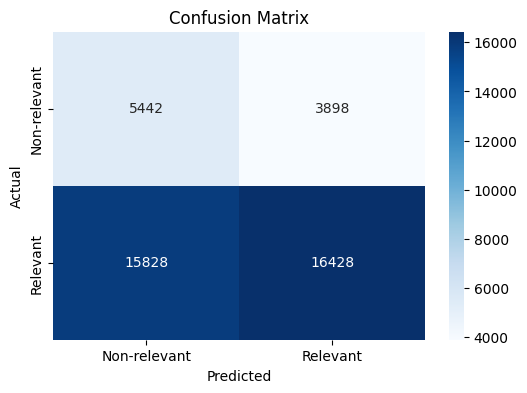

Confusion Matrix:
[[ 5442  3898]
 [15828 16428]]


In [55]:
# Define a threshold for relevance (e.g., ratings >= 4 are relevant)
threshold = 4

# Binarize the actual and predicted ratings
actual_relevance = (np.array(actual_ratings) >= threshold).astype(int)
predicted_relevance = (np.array(predicted_ratings) >= threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(actual_relevance, predicted_relevance)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-relevant', 'Relevant'], yticklabels=['Non-relevant', 'Relevant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


#### Mean Absolute Error

In [56]:
mae = mean_absolute_error(actual_ratings, predicted_ratings)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1.2376094769945465


#### Root Mean Squared Error

In [57]:
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.638022851172084


#### Precision

In [58]:
precision = precision_score(actual_relevance, predicted_relevance)
print(f'Precision: {precision}')

Precision: 0.8082259175440323


#### Recall

In [59]:
recall = recall_score(actual_relevance, predicted_relevance)
print(f'Recall: {recall}')

Recall: 0.5093005952380952


#### F1-Score

In [60]:
f1 = f1_score(actual_relevance, predicted_relevance)
print(f'F1 Score: {f1}')

F1 Score: 0.6248526111597125


#### ROC Curve

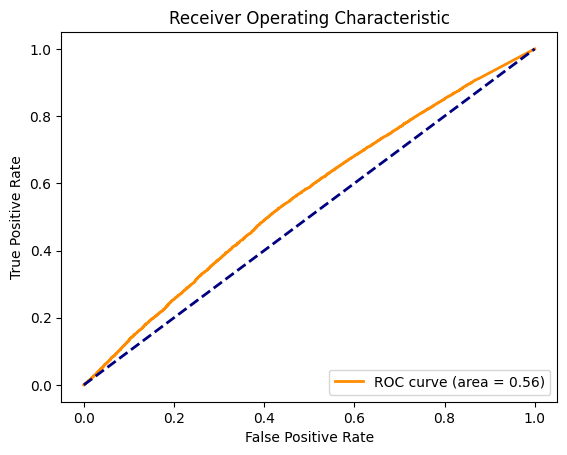

AUC: 0.56


In [61]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(actual_relevance, predicted_ratings)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Output AUC
print(f'AUC: {roc_auc:.2f}')
